In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import yfinance as yf
import fredapi as fa
from datetime import date, timedelta
from Sector_Exposure import Rate_Exposures
from Exposure_Report import Exposure
import numpy as np
import matplotlib.pyplot as plt
import Useful_Functions as u
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest
import statsmodels.api as sm
import math
import pandas_ta as ta


In [2]:
from itertools import combinations

def get_area(lst):
    
    assert len(lst) > 1, "list must have length of at least 2"
    combs = combinations(lst, 2)
    absolute_distance = 0
    for c in list(combs):
        absolute_distance += np.abs( c[0] - c[1] )
    return absolute_distance

def with_respect_to(df, compare, compare_against):
    
    with_respect = {}
    
    for i in df[compare].sort_values().unique():
        
        with_respect[i] = df[compare_against].loc[ df[compare] == i].mean()
    
    return pd.DataFrame(with_respect, index = ['mean_returns'])

def relative_difference(df, variable, difference):
    
    dist_range = round(df[variable].quantile(.75) - df[variable].quantile(.25), 3)
    
    return round(difference/dist_range, 3)

In [19]:

def set_up_data(df, exp):
    
    new_df = df.copy()
    for s, r in zip(new_df[compare_scores], compare_shortened):
        new_df[s] = exp.raw_scores[r]
    
    new_df['mean_of_scores'] = new_df[compare_scores].mean(axis=1)
    new_df['var_of_scores'] = new_df[compare_scores].var(axis=1)
    new_df['sum_of_scores'] = new_df[compare_scores].sum(axis=1)
    new_df['highest_score'] = new_df[compare_scores].max(axis=1)
    new_df['total_distance'] = [get_area(new_df[compare_scores].loc[d].to_list()) for d in new_df.index]
    
    return new_df


In [110]:


cutoff = .7

#sector_df = pd.read_csv("2006.csv", index_col="Date")

# Consumer Discretionary
sector = "Energy"
forward = 21

# , "SP-500"
compares = ['Real Yield', 'Yield Curve', "inflation", "uncertainty_index", 'market_volume', 'market_volatility']

leave_in = [sector, 'Real Yield', 'Yield Curve', "inflation", "uncertainty_index", 'market_volume', 'market_volatility', "SP-500"]
# [leave_in]
sector_df = pd.read_csv("macro_data.csv", index_col="Date")
for sec in sector_df.iloc[:,:11].columns:
    sector_df[f"{sec}_sma_spread"] = ta.sma(sector_df[sec], 30) - ta.sma(sector_df[sec], 120)
    leave_in.append(f"{sec}_sma_spread")
    

compare_shortened = [i for i in leave_in if i != "SP-500" and i != sector]
compare_shortened.append("SP-500")
train_df = sector_df[:int(len(sector_df)*cutoff)]
test_df = sector_df[int(len(sector_df)*cutoff):]

exposure = Exposure(test_df, 252, forward, compare_shortened, "SP-500")
exposure_train = Exposure(train_df, 252, forward, compare_shortened, "SP-500")

compare_scores = [f"{i}_scores" for i in compare_shortened]

train_df = set_up_data(exposure_train.forward_returns_daily.copy(), exposure_train)

test_df = set_up_data(exposure.forward_returns_daily.copy(), exposure)



In [111]:


above_market_train = train_df.iloc[:,len(exposure.sectors):].loc[ train_df[sector] > 0.0].mean()
below_market_train = train_df.iloc[:,len(exposure.sectors):].loc[ train_df[sector] <= 0.0].mean()

difference_above_below = pd.DataFrame([above_market_train, below_market_train], index = ["above market", "below market"]).T
difference_above_below['difference'] = abs(difference_above_below["above market"] - difference_above_below["below market"])

#abs(above_market_train - below_market_train)
#train_df['Real Yield_scores'].mean() - test_df['Real Yield_scores'].mean()


difference_above_below['relative_diff'] = [relative_difference(train_df, i, d)
                                               for i, d in zip(difference_above_below.index, difference_above_below.difference)]


difference_above_below


,above market,below market,difference,relative_diff
Real Yield_scores,-0.090330,0.241386,0.331715,0.126
Yield Curve_scores,-0.864592,-0.478205,0.386386,0.179
inflation_scores,-0.191673,-0.022302,0.169372,0.080
uncertainty_index_scores,-0.107827,-0.056799,0.051028,0.026
market_volume_scores,-0.083518,-0.029265,0.054253,0.032
market_volatility_scores,0.112705,-0.069227,0.181932,0.098
Materials_sma_spread_scores,-0.297813,0.008022,0.305836,0.137
Industrials_sma_spread_scores,-0.338862,0.174893,0.513755,0.212
Consumer Discretionary_sma_spread_scores,-0.215906,0.380211,0.596117,0.246
Consumer Staples_sma_spread_scores,-0.214958,0.019649,0.234607,0.080


In [113]:


def get_dist(var1, var2):
    
    rel1 = difference_above_below.loc[var1].loc["relative_diff"]
    rel2 = difference_above_below.loc[var2].loc["relative_diff"]
    
    y2_minus_y1 = (difference_above_below.loc[var1].loc["difference"] ** 2) * rel1
    x2_minus_x1 = (difference_above_below.loc[var2].loc["difference"] ** 2) * rel2

    dist = np.sqrt(y2_minus_y1 + x2_minus_x1)
    return dist

dists = {}

combs = combinations(list(difference_above_below.index), 2)
combos = list(combs)

for c in combos:
    
    dists[c] = get_dist(c[0], c[1])

dists = pd.DataFrame(dists, index = ['distance']).T

In [115]:


dists.sort_values(by="distance")[-30:]



,,distance
Health Care_sma_spread_scores,sum_of_scores,1.857683
Utilities_sma_spread_scores,sum_of_scores,1.858864
var_of_scores,sum_of_scores,1.859358
Financials_sma_spread_scores,sum_of_scores,1.863011
Technology_sma_spread_scores,sum_of_scores,1.864195
Industrials_sma_spread_scores,sum_of_scores,1.864765
SP-500_scores,sum_of_scores,1.871964
Consumer Discretionary_sma_spread_scores,sum_of_scores,1.873182
Telecomm_sma_spread_scores,total_distance,10.204087
highest_score,total_distance,10.204090


In [116]:
import plotly.express as px

train_df_for_visuals = train_df.copy()
train_df_for_visuals['above_market'] = (train_df[sector] > 0.0).astype(int)

test_df_for_visuals = test_df.copy()
test_df_for_visuals['above_market'] = (test_df[sector] > 0.0).astype(int)

# "above_market"
px.scatter(train_df_for_visuals, x = 'total_distance', y = 'sum_of_scores', color = 'above_market', hover_data=[sector, train_df_for_visuals.index])



In [118]:


X_train = train_df_for_visuals.drop(columns = exposure.sectors).drop(columns = ['above_market'])
Y_train = train_df_for_visuals['above_market']
X_test = test_df_for_visuals.drop(columns = exposure.sectors).drop(columns = ['above_market'])
Y_test = test_df_for_visuals['above_market']


In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


In [120]:


X_data = pd.concat([X_train, X_test], axis=0)

pca = PCA(n_components=2)
PCA_data = pca.fit_transform(X_data)

PCA_train = PCA_data[:len(Y_train)]
PCA_test = PCA_data[len(Y_train):]


In [121]:

knn = KNeighborsClassifier().fit(PCA_train, Y_train)

accuracy_score(Y_test, knn.predict(PCA_test))


0.5339966832504146

In [122]:

ok = {}

for i in range(5,200):
    
    kn = KNeighborsClassifier(n_neighbors=i).fit(PCA_train, Y_train)
    
    ok[i] = accuracy_score(Y_test, kn.predict(PCA_test))


<AxesSubplot:>

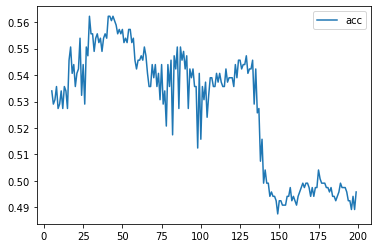

In [123]:


pd.DataFrame(ok, index = ['acc']).T.plot()



In [76]:


labels_with_index = pd.Series(Y_test)

colors_top_4 = {0 : "red", 1: 'green'}
ygrid = np.arange(min(PCA_test[:,0]), max(PCA_test[:,0])+5,.5)
xgrid = np.arange(min(PCA_test[:,1]),max(PCA_test[:,1])+5,.5)
xax, yax = np.meshgrid(xgrid, ygrid, indexing="ij")
z = np.zeros(xax.shape)
for i in range(len(xgrid)):
    for j in range(len(ygrid)):
        x = np.array([ygrid[j], xgrid[i]])
        z[i,j]= knn.predict(x[np.newaxis,:])

colorsnum = {0 : "red", 1: 'green'}
c = [colorsnum[i] for i in z.reshape(-1)]
plt.figure(figsize=(12,8))
plt.scatter(yax,xax, color=c, alpha=.1)
plt.scatter(PCA_test[:,0], PCA_test[:,1], c = labels_with_index.map(colors_top_4))
plt.xlabel("Principle Component 1", size = 26)
plt.ylabel("Principle Component 2", size = 26)
plt.title("Bayes Decision Boundaries Between Above and Below Market", size = 26)
plt.tight_layout()


KeyboardInterrupt: 

In [124]:


forest = RandomForestClassifier().fit(X_train, Y_train)
forest_preds = forest.predict(X_test)
accuracy_score(Y_test, forest_preds)



0.5572139303482587

In [126]:


assessment_df = pd.DataFrame()
assessment_df['actual'] = Y_test
assessment_df['preds'] = forest_preds
assessment_df['actual_rets'] = test_df_for_visuals[sector]
assessment_df.actual_rets.loc[ assessment_df['preds'] == 1].mean()



0.08761059320219684

In [127]:



assessment_df.loc[ assessment_df['preds'] == 1 ]

pd.Series(forest.feature_importances_, index = X_train.columns).sort_values()



uncertainty_index_scores                    0.020710
market_volume_scores                        0.021581
var_of_scores                               0.027118
highest_score                               0.028339
total_distance                              0.030970
mean_of_scores                              0.033193
inflation_scores                            0.036773
sum_of_scores                               0.036839
Financials_sma_spread_scores                0.037217
SP-500_scores                               0.038124
Yield Curve_scores                          0.039165
Real Yield_scores                           0.040008
Health Care_sma_spread_scores               0.042940
Consumer Staples_sma_spread_scores          0.043739
Technology_sma_spread_scores                0.044374
market_volatility_scores                    0.047257
Industrials_sma_spread_scores               0.051710
Materials_sma_spread_scores                 0.054779
Energy_sma_spread_scores                    0.

<AxesSubplot:>

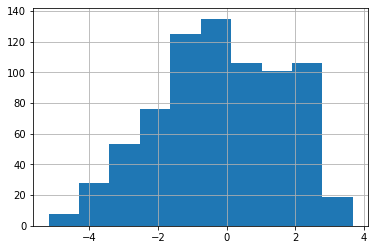

In [142]:




train_df['Utilities_sma_spread_scores'].loc[ train_df.Utilities > 0.0 ].hist()




In [109]:


custom_df = pd.DataFrame()
custom_df[sector] = exposure_train.forward_returns_daily[sector]
custom_df['Real Yield_scores'] = exposure_train.forward_returns_daily['Real Yield_scores']
custom_df['inflation_scores_monthly'] = exposure_train.forward_returns_monthly['inflation_scores']


In [110]:


custom_df.iloc[:,1:].loc[custom_df.Utilities > 0.0].mean()



Real Yield_scores           0.255319
inflation_scores_monthly    0.032258
dtype: float64